# Code v3

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [58]:
ruta_csv = "/content/nutec_dataset_ramp.csv"
df = pd.read_csv(ruta_csv, encoding='ISO-8859-1')
# Limpieza rápida: imputación de datos faltantes
df.fillna(df.median(numeric_only=True), inplace=True)

In [59]:
# Variables categóricas (si existen, imputación simple)
#for column in df.select_dtypes(include=['object']).columns:
#    df[column].fillna(df[column].mode()[0], inplace=True)

# Assuming 'df' is your DataFrame

# Get a list of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Create a dictionary to store the mappings for each column
categorical_mappings = {}

# Iterate through each categorical column
for col in categorical_cols:
    # Get unique values in the column
    unique_values = df[col].unique()

    # Create a mapping dictionary for the column
    mapping = {value: i for i, value in enumerate(unique_values)}

    # Store the mapping in the main dictionary
    categorical_mappings[col] = mapping

    # Apply the mapping to the column in the DataFrame
    df[col] = df[col].map(mapping)

print(categorical_mappings)
# Now, your categorical columns are converted to numerical using assigned numbers.

{'Empty or loaded for TUS': {'Empty': 0, 'Loaded': 1, 'Empty with heat sinks': 2, 'Empty heat up load test': 3}, 'Tipo de Horno': {'Fuego directo': 0, 'Recirculacion': 1}, 'Posicion del termopar de control con respecto a la carga u horno': {'Pared Lateral, parte baja de la carga': 0, 'Pared lateral': 1, nan: 2, 'Pared Lateral, parte media de la carga': 3, 'Pared Lateral, parte alta de la carga': 4, 'Pared Trasera, parte alta de la carga': 5, 'Pared trasera': 6}, 'Posicion del termopar de control con respecto al bafle': {nan: 0, 'Por dentro del bafle': 1, 'En la zona de carga': 2}, 'Tipo de aislamiento del carro o piso': {'Refractario duro': 0, 'Fibra': 1, nan: 2}, 'Ubicacion de las zonas': {'Izquierda y derecha': 0, nan: 1, 'Verticales a lo largo': 2, 'Al frente y atras': 3}, 'Tipo de  Controlador': {'HC900': 0, 'Compact Logix': 1, 'Siemens 1500': 2, 'Micro 800': 3, 'EuroTherm 3504': 4}, 'Algoritmo de lectura de temperatura (Directo, promedio, ponderado, etc)': {'Directo': 0, 'Promedio

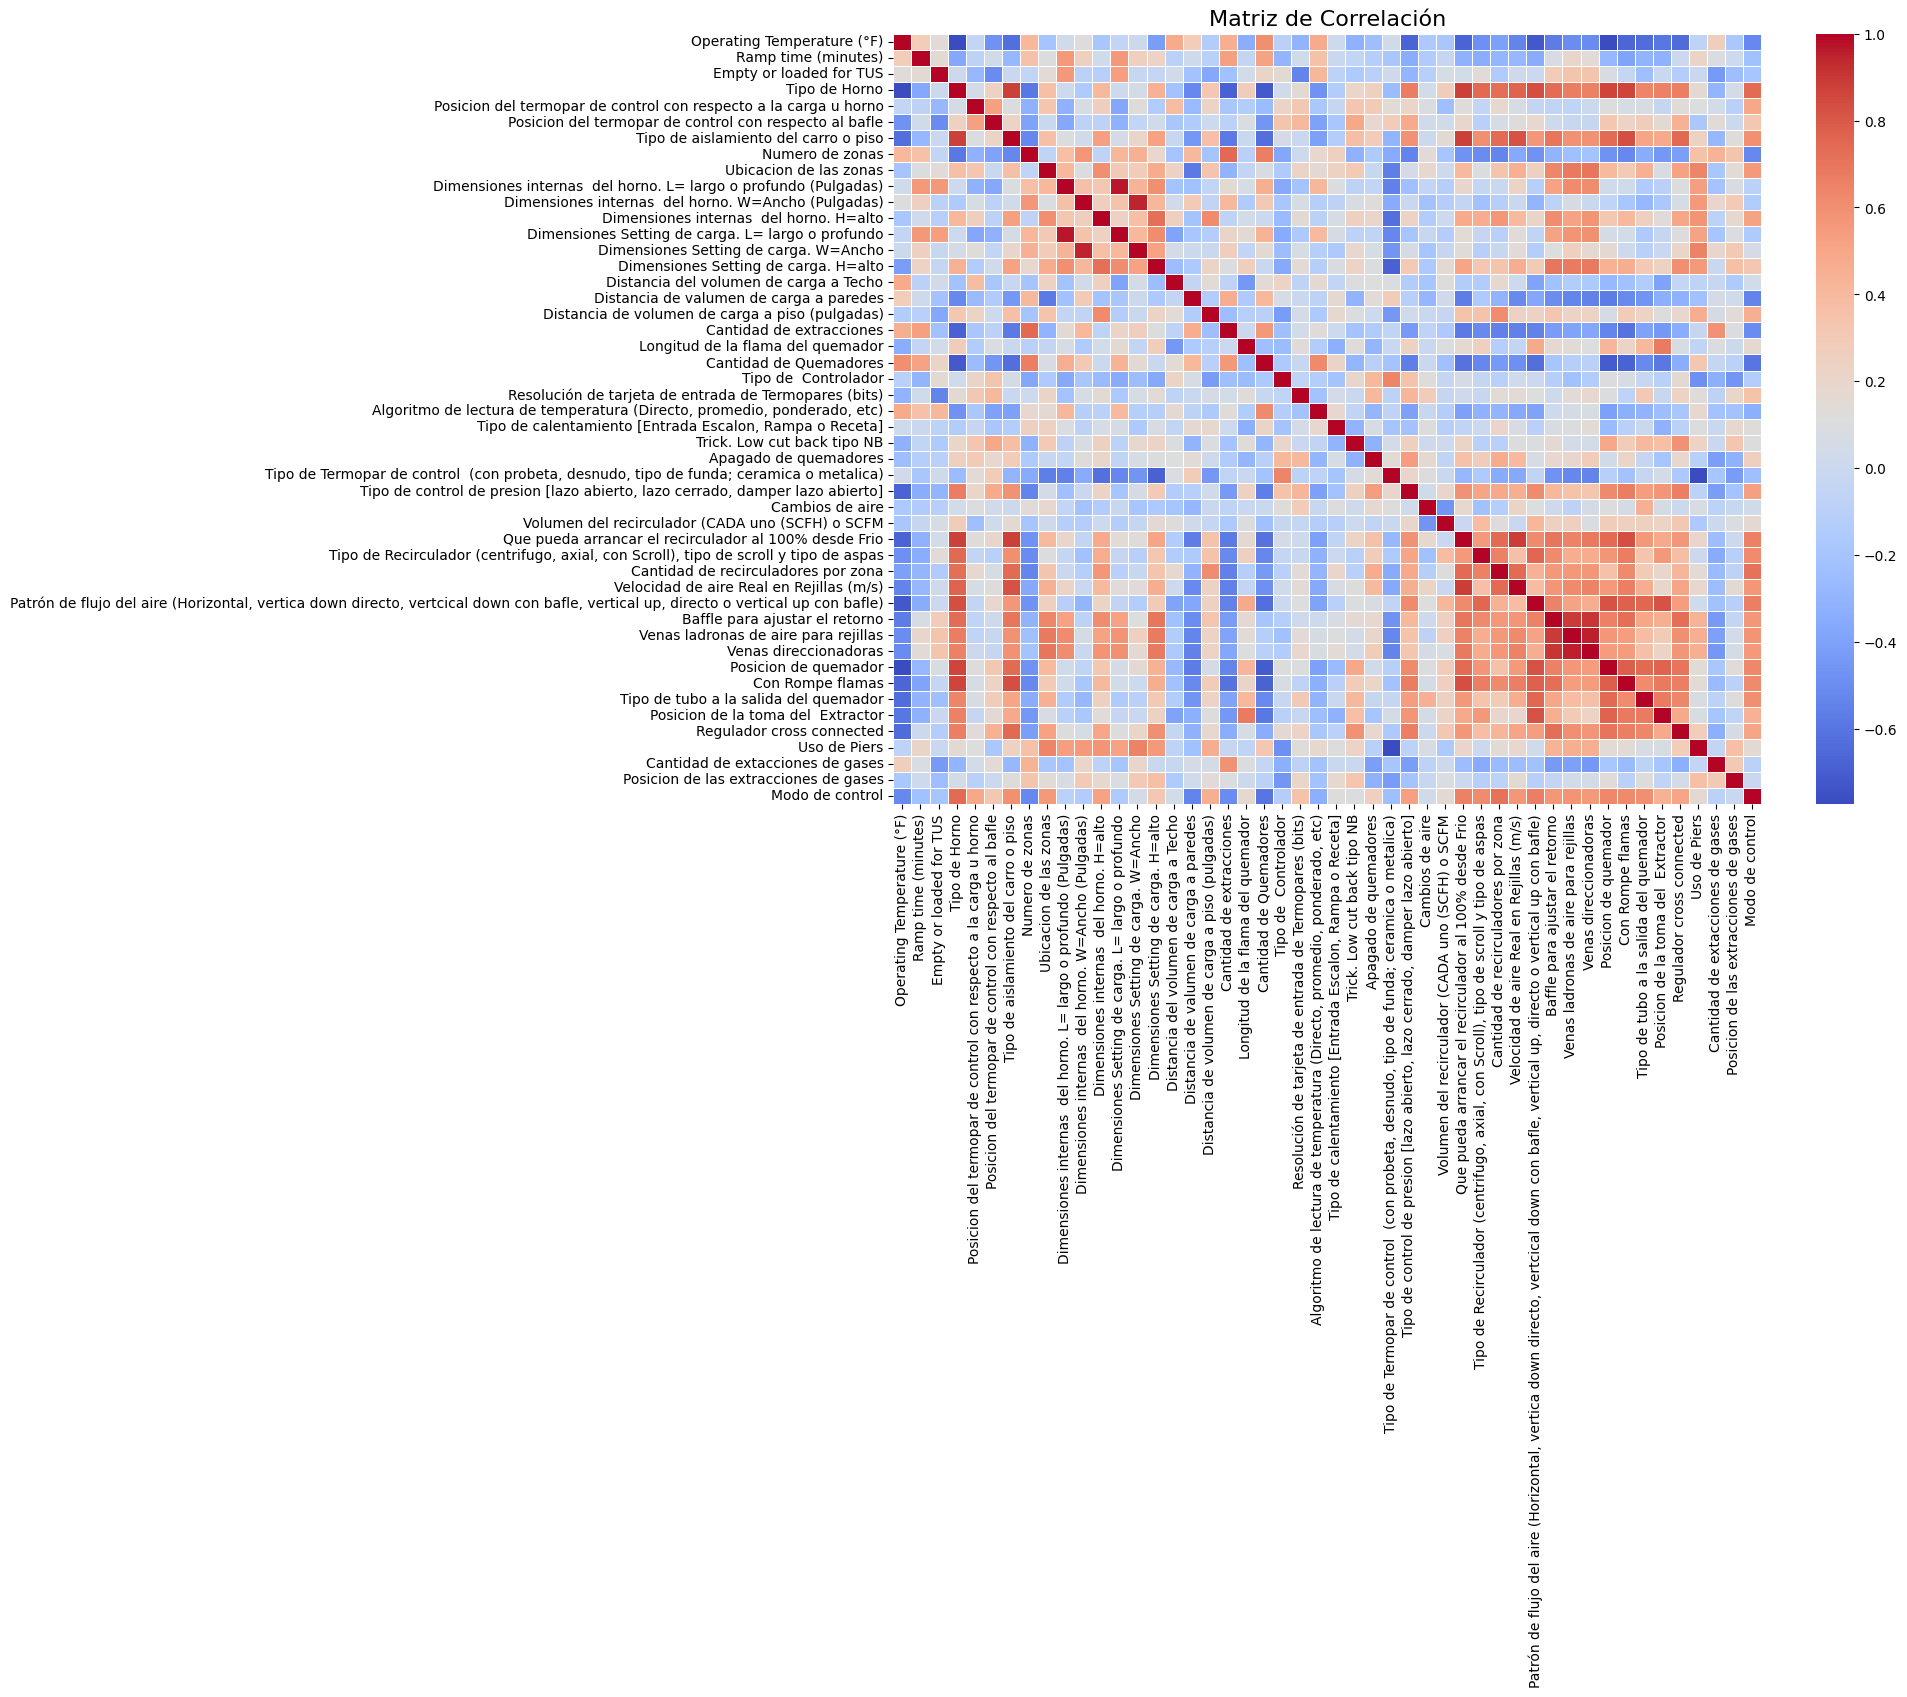

In [60]:
# Paso clave: Matriz de correlación, solo para columnas numéricas
# Se excluyen las columnas que no son numéricas usando select_dtypes
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()

# Visualización gráfica: Matriz de correlación
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

Correlación con Ramp time (minutes):
Con Rompe flamas                                                                                                                      -0.385548
Tipo de Horno                                                                                                                         -0.364622
Patrón de flujo del aire (Horizontal, vertica down directo, vertcical down con bafle, vertical up, directo o vertical up con bafle)   -0.349017
Tipo de Recirculador (centrifugo, axial, con Scroll), tipo de scroll y tipo de aspas                                                  -0.342268
Tipo de control de presion [lazo abierto, lazo cerrado, damper lazo abierto]                                                          -0.336874
Que pueda arrancar el recirculador al 100% desde Frio                                                                                 -0.312632
Posicion de la toma del  Extractor                                                                 

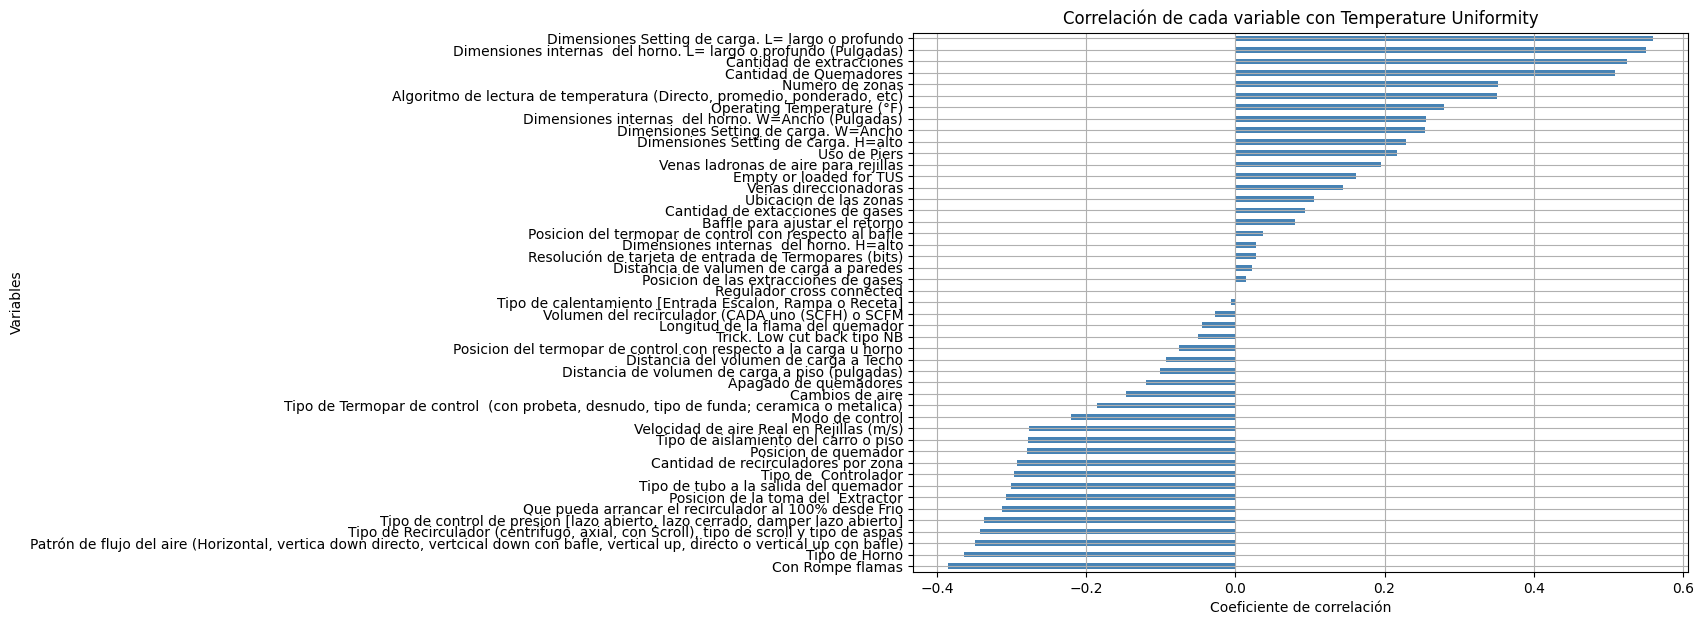

In [61]:
# Correlaciones específicas con la variable objetivo
# Asegúrate de que 'Temperature Uniformity' sea una columna numérica
target_variable_name = 'Ramp time (minutes)'
target_corr = None
if target_variable_name in numeric_df.columns:
    target_corr = correlation_matrix[target_variable_name].sort_values()
    print("Correlación con Ramp time (minutes):")
    print(target_corr)

    # Gráfica para ver correlaciones claramente
    #target_corr.drop(['Temperature Uniformity (+/- °F)', 'Ramp time (minutes)', 'Lag Time (minutes)'])
    target_corr.drop(target_variable_name).plot(kind='barh', figsize=(10,7), color='steelblue')
    plt.xlabel('Coeficiente de correlación')
    plt.ylabel('Variables')
    plt.title('Correlación de cada variable con Temperature Uniformity')
    plt.grid(True)
    plt.show()
else:
    print("La columna 'Temperature Uniformity' no es numérica o no está presente en el DataFrame.")

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('/content/nutec_dataset_ramp.csv', encoding='ISO-8859-1')


correlation_threshold = 0.45  # 0.4
nunique_threshold_for_categorical = 10

correlations_predictors = target_corr.drop(target_variable_name, errors='ignore')
#print(correlations_predictors)
#correlations_predictors = target_corr.drop(['Temperature Uniformity (+/- °F)', 'Ramp time (minutes)', 'Lag Time (minutes)'], axis=1, errors='ignore')
#print(correlations_predictors)

# Identify highly correlated features
highly_correlated_features_series = correlations_predictors[abs(correlations_predictors) > correlation_threshold]
selected_predictor_names = highly_correlated_features_series.index.tolist()

print(f"\nPredictores seleccionados automáticamente (correlación absoluta > {correlation_threshold}):")
if not selected_predictor_names:
    print("  Ningún predictor cumple el criterio de correlación.")
else:
    for name, corr_value in highly_correlated_features_series.items():
        print(f"- '{name}' (Correlación: {corr_value:.4f})")

relevant_columns_auto = [target_variable_name] + selected_predictor_names
relevant_columns_auto = [col for col in relevant_columns_auto if col in df.columns]

categorical_cols = []
numerical_cols = []
print("\nClasificación de predictores seleccionados (categóricos/numéricos):")
for col_name in selected_predictor_names:
    if df[col_name].nunique() <= nunique_threshold_for_categorical:
        categorical_cols.append(col_name)
        print(f"  - '{col_name}' (Numérica, {df[col_name].nunique()} únicos) -> Categórica (por heurística)")
    else:
        numerical_cols.append(col_name)
        print(f"  - '{col_name}' (Numérica, {df[col_name].nunique()} únicos) -> Numérica")

print("\nColumnas categóricas seleccionadas automáticamente (predictores):")
if categorical_cols:
    print(categorical_cols)
else:
    print("  Ninguna columna categórica seleccionada.")

print("\nColumnas numéricas seleccionadas automáticamente (predictores):")
if numerical_cols:
    print(numerical_cols)
else:
    print("  Ninguna columna numérica seleccionada.")

df = df[relevant_columns_auto].copy()


for col in categorical_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip().str.lower() # Example cleaning

for col in numerical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)

df[target_variable_name] = pd.to_numeric(df[target_variable_name], errors='coerce')
df.dropna(subset=[target_variable_name], inplace=True)

X = df.drop(target_variable_name, axis=1)
y = df[target_variable_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Number of features after one-hot encoding: {X_train.shape[1]}")
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

feature_names = X.columns
for feature, coef in zip(feature_names, model.coef_):
  print(f"  {feature}: {coef}")


Predictores seleccionados automáticamente (correlación absoluta > 0.45):
- 'Cantidad de Quemadores' (Correlación: 0.5094)
- 'Cantidad de extracciones' (Correlación: 0.5253)
- 'Dimensiones internas  del horno. L= largo o profundo (Pulgadas)' (Correlación: 0.5507)
- 'Dimensiones Setting de carga. L= largo o profundo' (Correlación: 0.5597)

Clasificación de predictores seleccionados (categóricos/numéricos):
  - 'Cantidad de Quemadores' (Numérica, 8 únicos) -> Categórica (por heurística)
  - 'Cantidad de extracciones' (Numérica, 4 únicos) -> Categórica (por heurística)
  - 'Dimensiones internas  del horno. L= largo o profundo (Pulgadas)' (Numérica, 17 únicos) -> Numérica
  - 'Dimensiones Setting de carga. L= largo o profundo' (Numérica, 18 únicos) -> Numérica

Columnas categóricas seleccionadas automáticamente (predictores):
['Cantidad de Quemadores', 'Cantidad de extracciones']

Columnas numéricas seleccionadas automáticamente (predictores):
['Dimensiones internas  del horno. L= largo o 

In [67]:
# prompt: Implement Lasso Regression as a replace for regular linear regression, as seen in past code block

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale features (Lasso is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implement Lasso Regression
# You may need to tune the alpha parameter (regularization strength)
# A larger alpha means stronger regularization (more coefficients shrink to zero)
lasso_model = Lasso(alpha=1.0, random_state=42) # You can change alpha

# Fit the Lasso model
lasso_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate the Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Lasso Regression Results ---")
print(f"Mean Squared Error (Lasso): {mse_lasso}")
print(f"R-squared (Lasso): {r2_lasso}")

print("\nLasso Coefficients (Scaled Features):")
# Map coefficients back to original feature names
feature_names = X.columns
for feature, coef in zip(feature_names, lasso_model.coef_):
  print(f"  {feature}: {coef}")

print("Lasso Intercept:", lasso_model.intercept_)

# Optional: Show which features had their coefficients shrunk to exactly zero by Lasso
print("\nFeatures with coefficients shrunk to zero by Lasso:")
for feature, coef in zip(feature_names, lasso_model.coef_):
    if abs(coef) < 1e-9: # Check if coefficient is close to zero
        print(f"  {feature}")


--- Lasso Regression Results ---
Mean Squared Error (Lasso): 11286.0225844343
R-squared (Lasso): 0.7324268515047927

Lasso Coefficients (Scaled Features):
  Dimensiones internas  del horno. L= largo o profundo (Pulgadas): 66.62195856061166
  Dimensiones Setting de carga. L= largo o profundo: -55.50692160333079
  Cantidad de Quemadores_1.0: 27.691657492406016
  Cantidad de Quemadores_2.0: 34.60063774351698
  Cantidad de Quemadores_3.0: 0.0
  Cantidad de Quemadores_4.0: -1.816925605877561
  Cantidad de Quemadores_6.0: -10.58085782788176
  Cantidad de Quemadores_8.0: -15.81142070993804
  Cantidad de Quemadores_9.0: -31.33696999408452
  Cantidad de Quemadores_15.0: 47.700381754536586
  Cantidad de Quemadores_nan: 0.0
  Cantidad de extracciones_0.0: -18.431406589927807
  Cantidad de extracciones_1.0: -60.41235321899511
  Cantidad de extracciones_2.0: 40.977793946634975
  Cantidad de extracciones_4.0: 40.798405606746385
  Cantidad de extracciones_nan: 0.0
Lasso Intercept: 172.6978787878788


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+02, tolerance: 8.562e+01
  model = cd_fast.enet_coordinate_descent(


In [68]:
# prompt: Implement Decision Tree with a very constrained max_depth as a replace for regular linear regression, as seen in past code block

from sklearn.tree import DecisionTreeRegressor

# Implement Decision Tree Regressor
# We are constraining max_depth significantly, for example, max_depth=3
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Fit the Decision Tree model
# Note: Decision Trees are not sensitive to feature scaling, so we use the unscaled data
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the Decision Tree model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("\n--- Decision Tree Regression Results (max_depth=3) ---")
print(f"Mean Squared Error (Decision Tree): {mse_dt}")
print(f"R-squared (Decision Tree): {r2_dt}")

# Optional: Visualize the tree (requires graphviz)
!pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt_model, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_regressor") # Saves to a file named decision_tree_regressor.pdf or .png

print("\nDecision Tree structure (using export_text):")
from sklearn.tree import export_text
tree_rules = export_text(dt_model, feature_names=list(X.columns))
print(tree_rules)




--- Decision Tree Regression Results (max_depth=3) ---
Mean Squared Error (Decision Tree): 11255.161183359955
R-squared (Decision Tree): 0.733158524881366

Decision Tree structure (using export_text):
|--- Cantidad de Quemadores_15.0 <= 0.50
|   |--- Cantidad de extracciones_1.0 <= 0.50
|   |   |--- Cantidad de Quemadores_2.0 <= 0.50
|   |   |   |--- value: [191.07]
|   |   |--- Cantidad de Quemadores_2.0 >  0.50
|   |   |   |--- value: [362.50]
|   |--- Cantidad de extracciones_1.0 >  0.50
|   |   |--- Dimensiones internas  del horno. L= largo o profundo (Pulgadas) <= 194.00
|   |   |   |--- value: [66.89]
|   |   |--- Dimensiones internas  del horno. L= largo o profundo (Pulgadas) >  194.00
|   |   |   |--- value: [169.36]
|--- Cantidad de Quemadores_15.0 >  0.50
|   |--- value: [470.67]



In [56]:
# prompt: Implement Random forest regressor and cross validation given the small dataset with a very constrained max_depth as a replace for regular linear regression, as seen in past code block

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Implement Random Forest Regressor
# We are constraining max_depth significantly, for example, max_depth=3
# You can also adjust n_estimators (number of trees)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Regression Results (max_depth=3) ---")
print(f"Mean Squared Error (Random Forest): {mse_rf}")
print(f"R-squared (Random Forest): {r2_rf}")

# Optional: Display feature importances from the Random Forest model
print("\nRandom Forest Feature Importances:")
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Implement Cross-Validation
# Using KFold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the Random Forest model
# We use the negative mean squared error as the scoring metric because cross_val_score maximizes the score.
# We then negate it to get the positive MSE.
cv_scores_mse = -cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

print("\n--- Cross-Validation Results (Random Forest, 5 Folds) ---")
print(f"Cross-Validation MSE Scores: {cv_scores_mse}")
print(f"Mean Cross-Validation MSE: {cv_scores_mse.mean()}")
print(f"Standard Deviation of Cross-Validation MSE: {cv_scores_mse.std()}")

print(f"\nCross-Validation R-squared Scores: {cv_scores_r2}")
print(f"Mean Cross-Validation R-squared: {cv_scores_r2.mean()}")
print(f"Standard Deviation of Cross-Validation R-squared: {cv_scores_r2.std()}")



--- Random Forest Regression Results (max_depth=3) ---
Mean Squared Error (Random Forest): 9.061301129720619
R-squared (Random Forest): 0.7881162264701588

Random Forest Feature Importances:
Tipo de control de presion [lazo abierto, lazo cerrado, damper lazo abierto]_lazo abierto                                                                            0.364538
Operating Temperature (°F)                                                                                                                                           0.235211
Patrón de flujo del aire (Horizontal, vertica down directo, vertcical down con bafle, vertical up, directo o vertical up con bafle)_vertical                         0.162275
Tipo de control de presion [lazo abierto, lazo cerrado, damper lazo abierto]_lazo cerrado damper paletas                                                             0.041805
Patrón de flujo del aire (Horizontal, vertica down directo, vertcical down con bafle, vertical up, directo o ver